In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

2022-11-16 21:25:23.032669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 21:25:23.196053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 21:25:23.196113: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-16 21:25:23.220829: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 21:25:23.876902: W tensorflow/stream_executor/platform/de

In [2]:
train_df = pd.read_csv('train_1Dy.csv',nrows=1000000)
test_df = pd.read_csv('test_1Dy.csv',nrows=50000)

In [3]:
X_train = train_df.drop(columns=['y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-midplane','cotBeta']).values

y_train = train_df['y-midplane'].values
y_test = test_df['y-midplane'].values

In [4]:
# scale so that it is between 0 and 1
def scale(X):
    width = np.max(X) - np.min(X)
    return ( X-np.min(X) ) / width

In [5]:
X_train = scale(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scale(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [6]:
def custom_loss(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = 0.1+tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
        
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("relu", name="relu1")(x)
    #x = BatchNormalization()(x)
    x = Dense(2, name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=custom_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                896       
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 dense2 (Dense)              (None, 2)                 130       
                                                                 
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


2022-11-16 21:25:26.809600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 21:25:26.809984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 21:25:26.810055: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-16 21:25:26.810115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-16 21:25:26.810177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [8]:
es = EarlyStopping(patience=10,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=200, 
                    batch_size=4096,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/200
196/196 [==============================] - 2s 4ms/step - loss: 16.9855 - val_loss: 16.8016
Epoch 2/200
196/196 [==============================] - 1s 3ms/step - loss: 16.5284 - val_loss: 16.2286
Epoch 3/200
196/196 [==============================] - 1s 3ms/step - loss: 15.8160 - val_loss: 15.3577
Epoch 4/200
196/196 [==============================] - 1s 3ms/step - loss: 14.7800 - val_loss: 14.1392
Epoch 5/200
196/196 [==============================] - 1s 3ms/step - loss: 13.3473 - val_loss: 12.4603
Epoch 6/200
196/196 [==============================] - 1s 3ms/step - loss: 11.4378 - val_loss: 10.3365
Epoch 7/200
196/196 [==============================] - 1s 3ms/step - loss: 9.2324 - val_loss: 8.1610
Epoch 8/200
196/196 [==============================] - 1s 4ms/step - loss: 7.3384 - val_loss: 6.6471
Epoch 9/200
196/196 [==============================] - 1s 4ms/step - loss: 6.2196 - val_loss: 5.8547
Epoch 10/200
196/196 [==============================] - 1s 4ms/step - loss: 5.6

/tmp/ipykernel_213074/4052347745.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


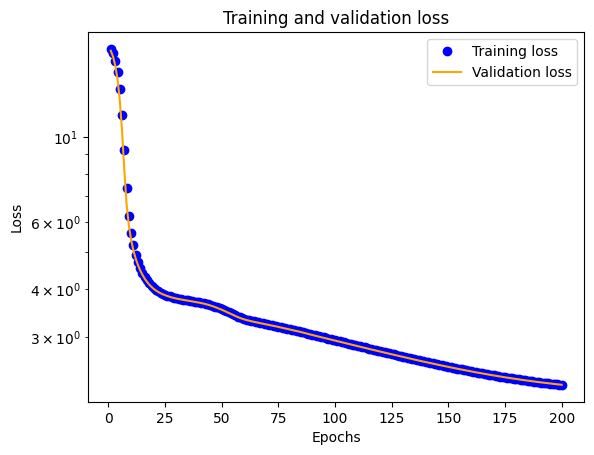

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()

In [10]:
model.save('models_1Dy/gauss.keras')

In [11]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['sigma'] = 0.1 + tf.math.softplus(df['sigma'])
df['ytrue'] = y_test
df.to_csv("test_1DyGauss.csv",header=False,index=False)

1563/1563 [==============================] - 1s 715us/step


In [12]:
residuals = y_test - p_test[:,0]
uncertainty= 0.1 + tf.math.softplus(p_test[:,1])

/tmp/ipykernel_213074/1616372605.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


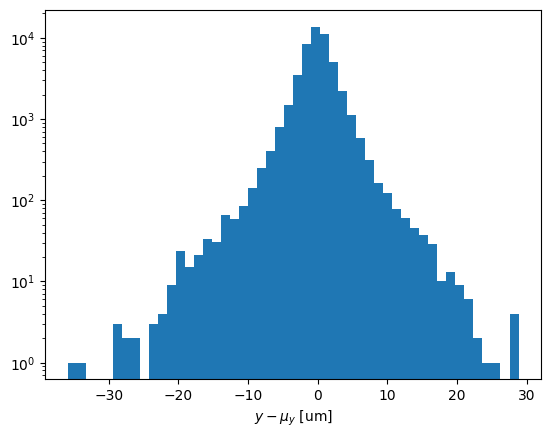

/tmp/ipykernel_213074/1616372605.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


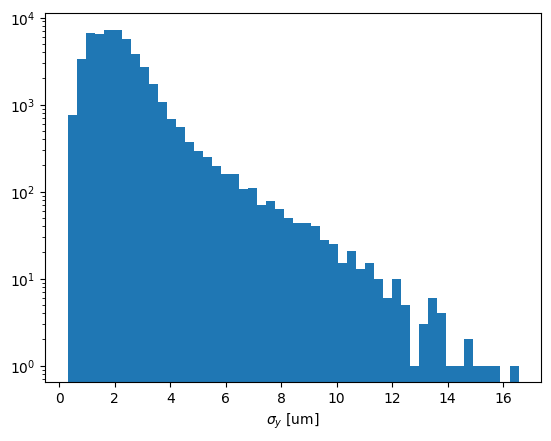

In [13]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')
plt.show()

plt.hist(p_test[:,1],bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma_y$ [um]')
plt.show()

In [14]:
pulls = residuals/p_test[:,1]

Text(0.5, 0, 'pull')

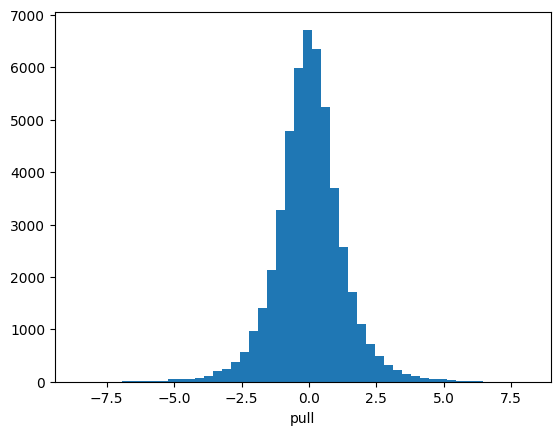

In [15]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [16]:
print(np.mean(pulls),np.std(pulls))

0.01210386811657965 1.264961245495388


In [17]:
model.layers

In [18]:
max(np.array(model.layers[1].get_weights()).flatten()[0].flatten())

/tmp/ipykernel_213074/2940326780.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  max(np.array(model.layers[1].get_weights()).flatten()[0].flatten())


3.2506566

In [19]:
model.layers[2].get_weights()

[]

In [20]:
np.max(np.array(model.layers[3].get_weights()).flatten())

/tmp/ipykernel_213074/446400839.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.max(np.array(model.layers[3].get_weights()).flatten())


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
x = sns.regplot(x=df['ytrue'], y=df['ytrue']-df['mu'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')

In [ ]:
y = sns.regplot(x=df['ytrue'], y=df['sigma'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$\sigma_y$ [um]')